In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import LSTM
from keras.layers import Dense

In [3]:
def split_series(series, n_past, n_future):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations 
    #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end], series[past_end:future_end]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [4]:
df = pd.read_csv("dataset_GBPUSD_EURUSD.csv")
spread = list(df["SPREAD"])

In [5]:
n_past = 10
n_future = 5 
n_features = 1

In [7]:
X_train, y_train = split_series(spread,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

In [9]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [10]:
print(n_timesteps, n_features, n_outputs)

10 1 5


In [11]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(32, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 182,205
Trainable params: 182,205
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
verbose, epochs = 1, 10

In [15]:
# fit network
history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose)

Epoch 1/10
1180/1180 [==============================] - 25s 21ms/step - loss: 0.0039
Epoch 2/10
1180/1180 [==============================] - 21s 18ms/step - loss: 0.0039
Epoch 3/10
1180/1180 [==============================] - 20s 17ms/step - loss: 0.0039
Epoch 4/10
1180/1180 [==============================] - 21s 17ms/step - loss: 0.0038
Epoch 5/10
1180/1180 [==============================] - 21s 18ms/step - loss: 0.0039
Epoch 6/10
1180/1180 [==============================] - 21s 18ms/step - loss: 0.0038
Epoch 7/10
1180/1180 [==============================] - 21s 18ms/step - loss: 0.0038
Epoch 8/10
1180/1180 [==============================] - 22s 18ms/step - loss: 0.0038
Epoch 9/10
1180/1180 [==============================] - 21s 18ms/step - loss: 0.0038
Epoch 10/10
1180/1180 [==============================] - 22s 18ms/step - loss: 0.0038


dict_keys(['loss'])


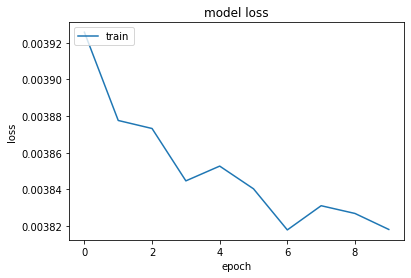

In [16]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
prediction_steps = 10
# demonstrate prediction
predictions = []

x_input = X_train[-1:]
x_input = np.delete(x_input, 0)
x_input = np.append(x_input, spread[-1])
x_input = x_input.reshape((1, n_past, n_features))
for i in range(prediction_steps):    
    yhat = model.predict(x_input)
    print(yhat)
    predictions.append(yhat[0][0])
    x_input = np.delete(x_input, 0)
    x_input = np.append(x_input, yhat[0][0])
    print(x_input)
    x_input = x_input.reshape((1, n_past, n_features))
print(predictions)

[[-1.3646517 -1.3640358 -1.3615992 -1.3613198 -1.3479785]]
[-1.34172187 -1.36768076 -1.3961812  -1.39491042 -1.36407663 -1.36407663
 -1.3774684  -1.3842089  -1.35810939 -1.36465168]
[[-1.3692145 -1.3686345 -1.3663111 -1.3657467 -1.352334 ]]
[-1.36768076 -1.3961812  -1.39491042 -1.36407663 -1.36407663 -1.3774684
 -1.3842089  -1.35810939 -1.36465168 -1.36921453]
[[-1.3737694 -1.3732504 -1.3710827 -1.3702985 -1.3569077]]
[-1.3961812  -1.39491042 -1.36407663 -1.36407663 -1.3774684  -1.3842089
 -1.35810939 -1.36465168 -1.36921453 -1.3737694 ]
[[-1.3787441 -1.3782772 -1.3762922 -1.3752832 -1.3619456]]
[-1.39491042 -1.36407663 -1.36407663 -1.3774684  -1.3842089  -1.35810939
 -1.36465168 -1.36921453 -1.3737694  -1.37874413]
[[-1.38369   -1.3831443 -1.3813237 -1.3801234 -1.3667718]]
[-1.36407663 -1.36407663 -1.3774684  -1.3842089  -1.35810939 -1.36465168
 -1.36921453 -1.3737694  -1.37874413 -1.38369   ]
[[-1.3878888 -1.3872107 -1.3853476 -1.3841836 -1.3707628]]
[-1.36407663 -1.3774684  -1.38420

In [25]:
merged_series = spread + predictions

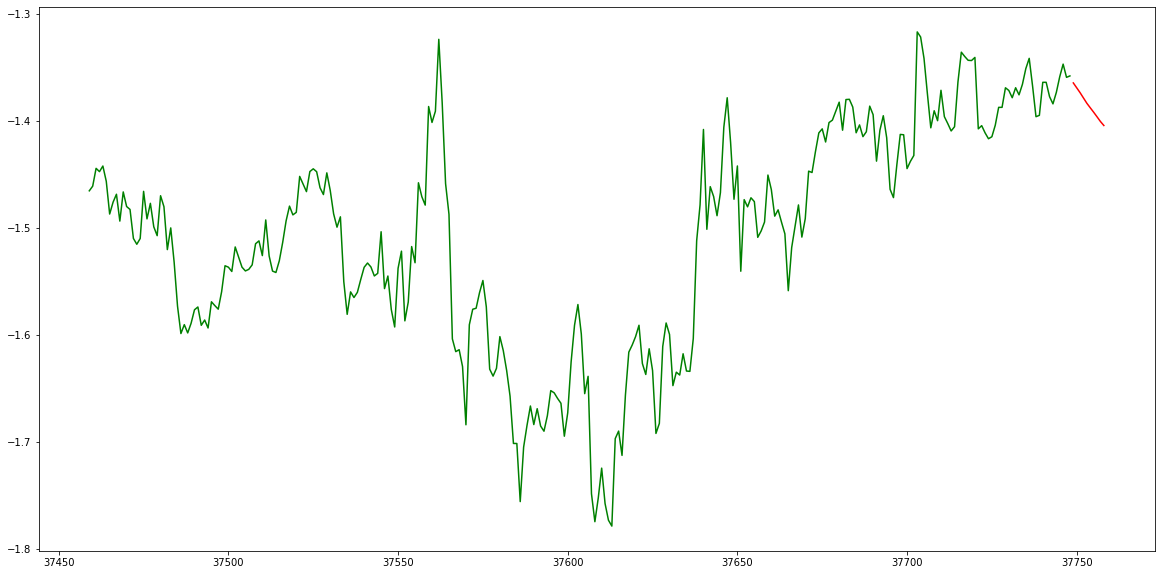

In [26]:
plt.figure(figsize=(20,10))
df = pd.Series(merged_series) 
ax = df[len(merged_series) - 300:len(merged_series) - prediction_steps].plot(color='g')
df[len(merged_series) - prediction_steps:].plot(ax=ax, color='r')
plt.show()